## Table of Content
1. [Load Data](#Load-Data)
2. [Feature Extraction](#Feature-Extraction)
3. [TimeSeriesSplit](#TimeSeriesSplit)
4. [Transform to Supervised Setup](#transform-to-supervised-setup)
5. [Train LSTM-based autoencoder](#train-lstm-based-autoencoder)
6. [Train MLP regressor](#train-mlp-regressor)
7. [Feedback Needed](#feedback-needed)
8. [Appendix: Data Preparation](#appendix-data-preparation)

## Project Goal

The goal of this project is to predict 20-day return of stock `AAPL`. While modern advances in transformers are promising for time-series forecasting, recent works show that MLPs and linear models have comparable capabilities in some tasks. Inspired by such work, we implement an ensemble of linear models with different lookback period to predict 20-day return of stock `AAPL`. We first obtain the raw data of quotes, financials, and fundamentals from yahoo finance. Then, we unify and preprocess the data format into a single `DataFrame`(see [Appendix](#appendix-data-preparation) for more details). With an unified data, we extract features of technical indicators from the data, split into train-val-test sets, standardize them, and then transform into a supervised setup. To denoise the data, we perform dimensionality reduction through training an autoencoder. Finally, we train multiple MLPs on the reduced data to perform forecasting.

## Load Data

The data loaded here has been combined and unified from multiple raw data sources. The dates are restricted to 2013/05/06 - 2023/04/26.

In [143]:
import pandas as pd
data = pd.read_csv('../prepared_data/data.csv')
data.columns

Index(['Unnamed: 0', 'Date', 'Open', 'Close', 'High', 'Low', 'Volume',
       'S&P500', 'PeRatio', 'PsRatio', 'PbRatio',
       'EnterpriseValueRevenueRatio', 'EnterpriseValueEDITDARatio',
       'BasicEPS'],
      dtype='object')

## Feature Extraction

The goal is to get these technical indicators. Most of them are implemented using an open-source library [`stock_indicators`](https://python.stockindicators.dev/).

- $n$-day return
- Typical Price = average of high, low, and close
- [Relative Strength Index](https://en.wikipedia.org/wiki/Relative_strength_index)
- [Stochastic Oscillator](https://en.wikipedia.org/wiki/Stochastic_oscillator)
- [Williams %R](https://www.investopedia.com/terms/w/williamsr.asp)
- [Moving Average Convergence Divergence(MACD)](https://www.investopedia.com/terms/m/macd.asp#:~:text=Moving%20average%20convergence%2Fdivergence%20(MACD%2C%20or%20MAC%2DD,from%20the%2012%2Dperiod%20EMA.)) = Short lookback EMA - Long lookback EMA
- [On-Balance Volume (OBV)](https://www.investopedia.com/terms/o/onbalancevolume.asp): Volume-based momentum
- [Commodity Channel Index (CCI)](https://www.investopedia.com/terms/c/commoditychannelindex.asp#:~:text=The%20Commodity%20Channel%20Index%20(CCI)%20is%20a%20technical%20indicator%20that,is%20below%20the%20historic%20average.): Evaluate the current price as opposed to the historical price
- $n$ days Moving Average
    - Simple Moving Average
    - Smoothed Moving Average
    - Exponential Moving Average
- [Average True Range (ATR)](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/atr#:~:text=Average%20True%20Range%20(ATR)%20is,daily%2C%20weekly%2C%20or%20monthly.): The average of the true range as a way to evaluate the volatility

In [144]:
import numpy as np
from stock_indicators import Quote, indicators
from datetime import datetime

def data_to_quotes(data): 
    # Transform the date dtype to be compatible with stock_indicators pkg
    data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
    # A list of Quotes for using stock_indicators
    aapl = [
        Quote(d,o,h,l,c,v) 
        for d,o,h,l,c,v 
        in zip(data['Date'], data['Open'], data['High'], data['Low'], data['Close'], data['Volume'])
    ]
    return aapl

def n_day_return(X, n): 
    '''
    n-day return is (current day closing price - n days ago opening price) / n days ago opening price. 
    
    Args: 
        X (np.ndarray): 
            np.ndarray with open, close 
        n (int): 
            The number of days ago. 
        
    Returns: 
        n_day_return (np.array): 
            An array of n-day return with shape (len(X),) where the first n entries would be none
    '''
    op = np.array(X.Open[:-n])
    cls = np.array(X.Close[n:])
    ret = (cls - op) / (op)
    res =  np.concatenate(([None for i in range(n)], ret), axis=0)
    return res.reshape((-1, 1))
    
def typical_price(X): 
    '''
    Typical price is the average of close, high, and low prices. 
    
    Args:
        X (np.ndarray): 
            np.ndarray with close, high, low columns. 
        
    Returns: 
        typical_price (np.array): 
            An array of typical price
    '''
    return (X.high + X.low + X.close) / 3

def relative_strength_index(quotes, n): 
    rsi_results = indicators.get_rsi(quotes, n) 
    rsi = []
    for rsi_result in rsi_results: 
        rsi.append(rsi_result.rsi)
    return np.array(rsi).reshape((-1, 1)) 

def stochastic_oscillator(quotes, n): 
    stoch_results = indicators.get_stoch(quotes, lookback_periods=n)
    stoch = [] 
    for stoch_result in stoch_results: 
        stoch.append(stoch_result.oscillator) 
    return np.array(stoch).reshape((-1, 1)) 

def william_r(quotes, n): 
    william_r_results = indicators.get_williams_r(quotes, lookback_periods=n)
    william_r = [] 
    for william_r_result in william_r_results: 
        william_r.append(william_r_result.williams_r)
    return np.array(william_r).reshape((-1, 1)) 

def macd(quotes, short_period, long_period): 
    macd_results = indicators.get_macd(quotes, fast_periods=short_period, slow_periods=long_period)
    macd = [] 
    for macd_result in macd_results: 
        macd.append(macd_result.macd) 
    return np.array(macd).reshape((-1, 1)) 

def on_balanced_volume(quotes, n): 
    obv_results = indicators.get_obv(quotes, sma_periods=n) 
    obv = []
    for obv_result in obv_results: 
        obv.append(obv_result.obv)
    return np.array(obv).reshape((-1, 1))

def commodity_channel_index(quotes, n): 
    cci_results = indicators.get_cci(quotes, lookback_periods=n)
    cci = []
    for cci_result in cci_results: 
        cci.append(cci_result.cci) 
    return np.array(cci).reshape((-1, 1)) 

def simple_moving_average(quotes, n): 
    sma_results = indicators.get_sma(quotes, n) 
    sma = []
    for sma_result in sma_results: 
        sma.append(sma_result.sma) 
    return np.array(sma).reshape((-1, 1))  

def smoothed_moving_average(quotes, n): 
    smma_results = indicators.get_smma(quotes, n) 
    smma = []
    for smma_result in smma_results: 
        smma.append(smma_result.smma)
    return np.array(smma).reshape((-1, 1))  

def exponential_moving_average(quotes, n): 
    ema_results = indicators.get_ema(quotes, n) 
    ema = []
    for ema_result in ema_results: 
        ema.append(ema_result.ema) 
    return np.array(ema).reshape((-1, 1)) 

def average_true_range(quotes, n): 
    atr_results = indicators.get_atr(quotes, n) 
    atr = [] 
    for atr_result in atr_results: 
        atr.append(atr_result.atr) 
    return np.array(atr).reshape((-1, 1)) 

We use a column transformer to concatenate all extracted features

In [145]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# Concatenate the columns
n = 30
short_period = n // 2 
long_period = n

pipeline = Pipeline([
    ('to_quotes', FunctionTransformer(data_to_quotes)), 
    ('rsi', FunctionTransformer(relative_strength_index, kw_args={'n': n}))
])

transformer = ColumnTransformer([
    ('original_features', 'passthrough', data.columns),
    ('rsi', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('rsi', FunctionTransformer(relative_strength_index, kw_args={'n': n}))
    ]), data.columns),
    ('stoch', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('stoch', FunctionTransformer(stochastic_oscillator, kw_args={'n': n}))
    ]), data.columns),
    ('william_r', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('william_r', FunctionTransformer(william_r, kw_args={'n': n}))
    ]), data.columns),
    ('macd', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('macd', FunctionTransformer(macd, kw_args={'short_period': short_period, 'long_period': long_period}))
    ]), data.columns),
    ('obv', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('obv', FunctionTransformer(on_balanced_volume, kw_args={'n': n}))
    ]), data.columns),
    ('cci', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('cci', FunctionTransformer(commodity_channel_index, kw_args={'n': n}))
    ]), data.columns),
    ('sma', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('sma', FunctionTransformer(simple_moving_average, kw_args={'n': n}))
    ]), data.columns),
    ('smma', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('smma', FunctionTransformer(smoothed_moving_average, kw_args={'n': n}))
    ]), data.columns),
    ('ema', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('ema', FunctionTransformer(exponential_moving_average, kw_args={'n': n}))
    ]), data.columns),
    ('atr', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('atr', FunctionTransformer(average_true_range, kw_args={'n': n}))
    ]), data.columns),
    ('5_day_return', FunctionTransformer(n_day_return, kw_args={'n': 5}), ['Open', 'Close']), 
    ('10_day_return', FunctionTransformer(n_day_return, kw_args={'n': 10}), ['Open', 'Close']), 
    ('n_day_return', FunctionTransformer(n_day_return, kw_args={'n': n}), ['Open', 'Close']),
    ('20_day_return', FunctionTransformer(n_day_return, kw_args={'n': 20}), ['Open', 'Close']), 
], remainder='passthrough')

# Drop the first and the second column which is indices and dates
full_data = transformer.fit_transform(data)[:, 1:]

Since some of the technical indicators require lookback, the first $n$ points would contain `None`. We choose to drop those data points.

In [146]:
prefix = 0 
while prefix < full_data.shape[0]: 
    if np.equal(full_data[prefix:], None).any():
        prefix += 1
    else: 
        break
full_data = full_data[prefix:]
print(full_data.shape)

(2481, 27)


## TimeSeriesSplit

We use [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit.split) to split the data into 3-fold to train and evaluate the model. In addition, `test set` is split into `validation set` and `test set` to tune the model. 

In [147]:
from sklearn.model_selection import TimeSeriesSplit 

tscv = TimeSeriesSplit(n_splits=3, max_train_size=900) 
folds = []
for i, (train_index, test_index) in enumerate(tscv.split(full_data)):
     # First 90 dates of test set
     validation_index = test_index[:90]
     test_index = test_index[90:]
     print(f"Fold {i}:")
     print(f"  Training set size = {len(train_index)}")
     print(f"  Validation set size = {len(validation_index)}")
     print(f"  Test set size = {len(test_index)}")
     print(f"  Training set start date = {full_data[train_index[0], 0]}")
     print(f"  Training set end date = {full_data[train_index[-1], 0]}")
     print(f"  Validation set start date = {full_data[validation_index[0], 0]}")
     print(f"  Validation set end date = {full_data[validation_index[-1], 0]}")
     print(f"  Test set start date = {full_data[test_index[0], 0]}")
     print(f"  Test set end date = {full_data[test_index[-1], 0]}")
     folds.append((train_index, validation_index, test_index))

Fold 0:
  Training set size = 621
  Validation set size = 90
  Test set size = 530
  Training set start date = 2013-06-19
  Training set end date = 2015-12-03
  Validation set start date = 2015-12-04
  Validation set end date = 2016-04-14
  Test set start date = 2016-04-15
  Test set end date = 2018-05-22
Fold 1:
  Training set size = 900
  Validation set size = 90
  Test set size = 530
  Training set start date = 2014-10-24
  Training set end date = 2018-05-22
  Validation set start date = 2018-05-23
  Validation set end date = 2018-09-28
  Test set start date = 2018-10-01
  Test set end date = 2020-11-05
Fold 2:
  Training set size = 900
  Validation set size = 90
  Test set size = 530
  Training set start date = 2017-04-12
  Training set end date = 2020-11-05
  Validation set start date = 2020-11-06
  Validation set end date = 2021-03-18
  Test set start date = 2021-03-19
  Test set end date = 2023-04-26


## Transform to Supervised Setup

A supervised setup consists of `X`, `y` where `X` are $n$ days lookback of all the features and `y` is 20-day return. In addition, to satisfy the shape requirement of using LSTM-based autoencoder, we need to shape the data to be $n \times \text{timestep} \times \text{d}$. We store all `X_train, y_train, X_val, y_val, X_test, y_test` of each fold into a `list` of `dict` called `fold_data`.

In [148]:
from sklearn.preprocessing import StandardScaler

def supervised_transformer(data, n): 
    X, y = data 
    X_result = np.ndarray((X.shape[0]-n, n, X.shape[1]))
    y_result = y[n:]
    for i in range(n, X.shape[0]): 
        X_result[i-n] = X[i-n:i]
    
    print(f'X\'s shape = {X_result.shape}')
    print(f'y\'s shape = {y_result.shape}')
    return X_result, y_result

n = 30
fold_data = []

for (train_index, validation_index, test_index) in folds: 
    X_train = full_data[train_index, 1:]
    y_train = full_data[train_index, -1]
    X_val = full_data[validation_index, 1:]
    y_val = full_data[validation_index, -1]
    X_test = full_data[test_index, 1:]
    y_test = full_data[test_index, -1]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    X_train, y_train = supervised_transformer((X_train, y_train), n)
    X_val, y_val = supervised_transformer((X_val, y_val), n)
    X_test, y_test = supervised_transformer((X_test, y_test), n)
    fold_data.append({
        'X_train': X_train, 
        'y_train': y_train,
        'X_val': X_val, 
        'y_val': y_val, 
        'X_test': X_test, 
        'y_test': y_test
    })

X's shape = (591, 30, 26)
y's shape = (591,)
X's shape = (60, 30, 26)
y's shape = (60,)
X's shape = (500, 30, 26)
y's shape = (500,)
X's shape = (870, 30, 26)
y's shape = (870,)
X's shape = (60, 30, 26)
y's shape = (60,)
X's shape = (500, 30, 26)
y's shape = (500,)
X's shape = (870, 30, 26)
y's shape = (870,)
X's shape = (60, 30, 26)
y's shape = (60,)
X's shape = (500, 30, 26)
y's shape = (500,)


## Train LSTM-based autoencoder

Financial time series data is generally more noisy than typical dataset. There are a number of denoising technique such as Principle Component Analysis(PCA), Exponential Smoothing, and other dimensionality reduction methods. Here we adopt LSTM-based autoencoder because LSTM captures the lookback property of the data we are dealing with and we do need some sort of long term memory as a way to encode previous days features. The idea of autoencoder is a neural network composed of two parts: Encoder and Decoder. Encoder takes a high dimensional input space and compress it through some layers into a lower dimensional hidden layer. Decoder reverses the process by taking the lower dimensional hidden layer reduced by Encoder and decompress it through some layers mirroring the dimension of the Encoder and restore the original input. This way, when the neural network forward passes to the lower dimensional space at the end of the Encoder, it does the dimensionality reduction and denoises the input data. The Decoder can be viewed as reconstructing the input through the lower dimension representation of the input. Training the autoencoder can be interpreted as dimensionality reduction that reaches the lowest reconstruction error. The following implementation is inspired [here](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352)

In [227]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Layer
import keras
import tensorflow as tf

n = 30 
d = full_data.shape[1] - 1

class Encoder(keras.layers.Layer): 
    def __init__(self, h1, h2, time_steps, n_features, **kwargs): 
        super(Encoder, self).__init__(**kwargs)
        self.layer1 = LSTM(h1, activation='relu', input_shape=(time_steps, n_features), return_sequences=True)
        self.layer2 = LSTM(h2, activation='relu', return_sequences=False, kernel_regularizer=tf.keras.regularizers.L2(0.01))
    
    def call(self, x):
        x = self.layer1(x)
        return self.layer2(x)

class Decoder(keras.layers.Layer): 
    def __init__(self, h1, h2, time_steps, n_features, **kwargs): 
        super(Decoder, self).__init__(**kwargs)
        self.layer1 = LSTM(h2, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(0.01))
        self.layer2 = LSTM(h1, activation='relu', return_sequences=True)
        self.time_distributed = TimeDistributed(Dense(n_features, kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    
    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.time_distributed(x)
    
class AutoEncoder(tf.keras.Model): 
    def __init__(self, h1, h2, time_steps, n_features, **kwargs): 
        super(AutoEncoder, self).__init__(**kwargs)
        self.h1 = h1 
        self.h2 = h2 
        self.time_steps = time_steps 
        self.n_features = n_features
        self.encoder = Encoder(h1, h2, time_steps, n_features)
        self.repeat = RepeatVector(time_steps)
        self.decoder = Decoder(h1, h2, time_steps, n_features)
    
    def call(self, x): 
        x = self.encoder(x) 
        x = self.repeat(x) 
        return self.decoder(x)

epochs = 2100
X_train = fold_data[0]['X_train']
# Initialize the dataset
batch_size = 2048
train_dataset = tf.data.Dataset.from_tensor_slices((X_train))
train_dataset = train_dataset.batch(batch_size)
# model = keras.models.load_model("after_300_epochs")
model = AutoEncoder(64, 15, n, d)
# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Instantiate a loss function
loss_fn = tf.keras.losses.MeanSquaredError()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    # Iterate over the batches of a dataset.
    for x in train_dataset:
        # Open a GradientTape.
        with tf.GradientTape() as tape:
            # Forward pass.
            pred = model(x)
            # Loss value for this batch.
            loss_value = loss_fn(x, pred)
            # Output the loss after 10 epochs
            if epoch % 10 == 9:
                print(f'MSE = {loss_value}')

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        # Update the weights of the model.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        if epoch % 300 == 299: 
            model.save(f'ckpt_{epoch}')

Epoch 1
Epoch 2
Epoch 3
Epoch 4


KeyboardInterrupt: 

### Visualization of 20-day return reconstruction in `training set` and `validation set`

In [214]:
import matplotlib.pyplot as plt

models = ['ckpt_299', 'ckpt_599', 'ckpt_899', 'ckpt_1199', 'ckpt_1499', 'ckpt_1799', 'ckpt_2099']

X_val = fold_data[0]['X_val']
losses = []
for model_path in models:
    model = keras.models.load_model(model_path)
    X_hat_val = model.predict(X_val)

    loss_fn = tf.keras.losses.MeanSquaredError()
    losses.append(loss_fn(X_val, X_hat_val))
    # print(f'loss for {model_path} = {loss_fn(X_test, X_hat_val)}')
for i in range(len(losses)): 
    print(f'loss for {models[i]} = {losses[i]}')

2/2 [==============================] - 1s 565ms/step


2/2 [==============================] - 1s 582ms/step


2/2 [==============================] - 1s 563ms/step


2/2 [==============================] - 1s 614ms/step


2/2 [==============================] - 1s 625ms/step


2/2 [==============================] - 1s 652ms/step


2/2 [==============================] - 1s 600ms/step
loss for ckpt_299 = 1.4474146366119385
loss for ckpt_599 = 2.1652348041534424
loss for ckpt_899 = 1.2474488019943237
loss for ckpt_1199 = 1.1640777587890625
loss for ckpt_1499 = 1.1649739742279053
loss for ckpt_1799 = 1.2372572422027588
loss for ckpt_2099 = 1.1966426372528076


16/16 [==============================] - 6s 371ms/step


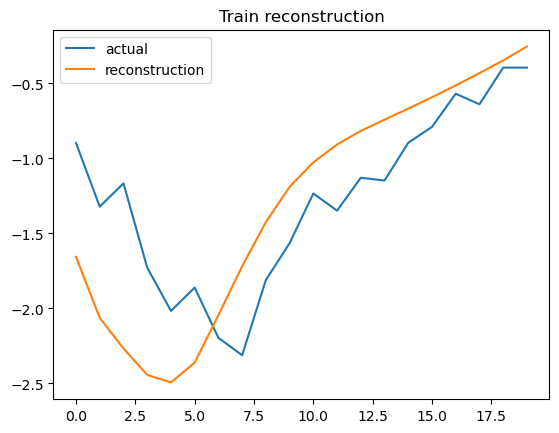

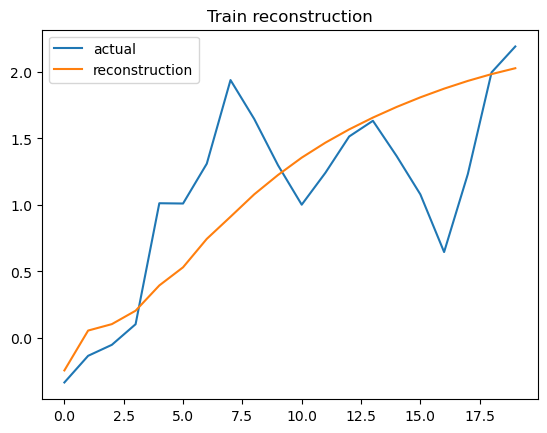

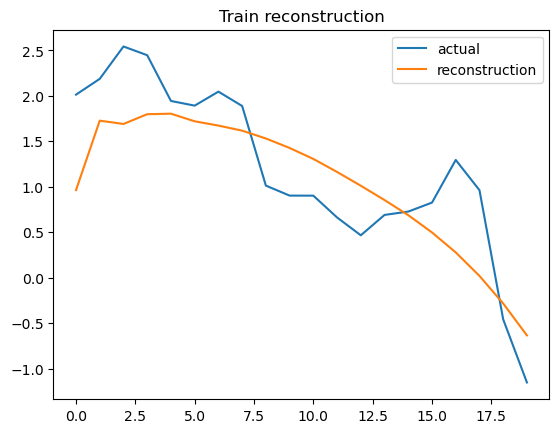

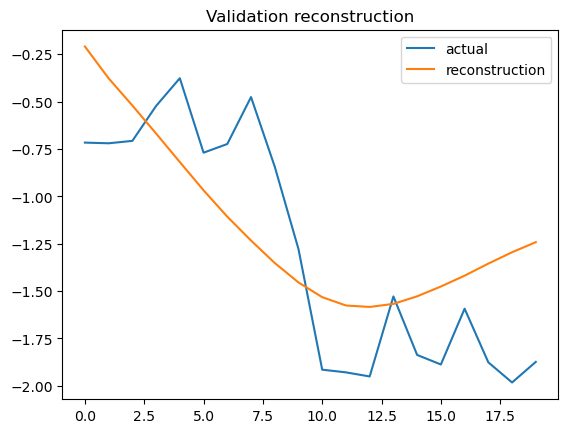

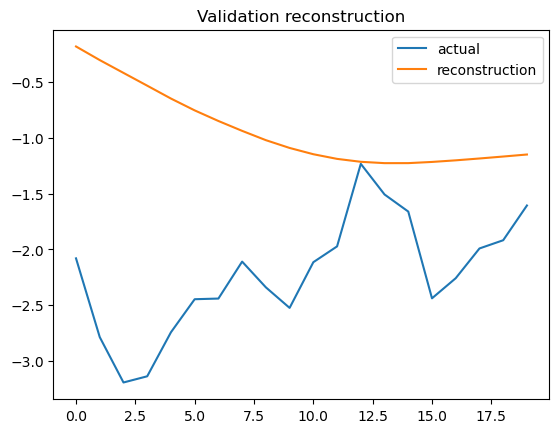

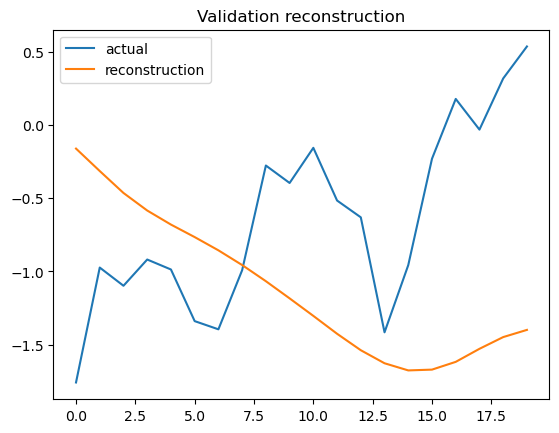

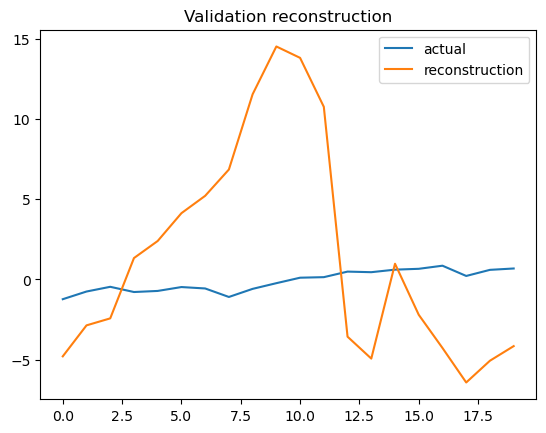

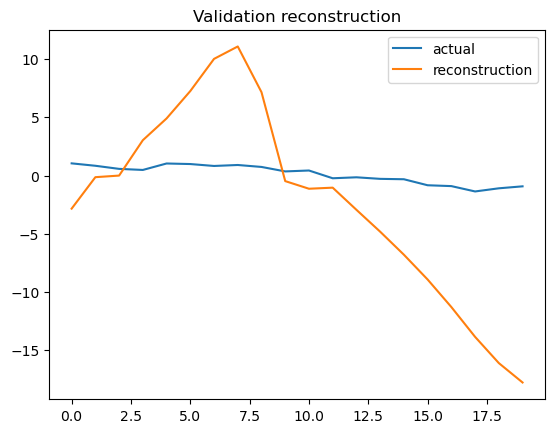

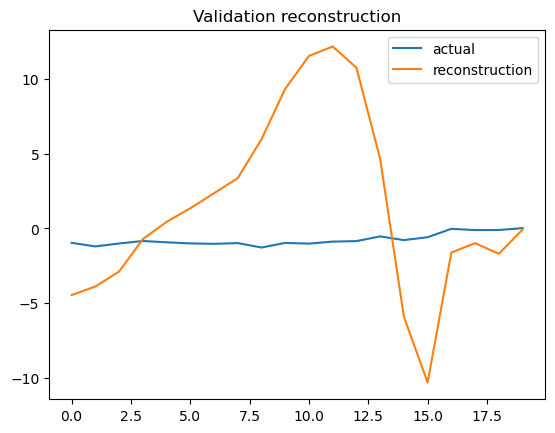

In [226]:
model = keras.models.load_model(models[np.argmax(losses)])
X_hat = model.predict(X_train)
X_hat_val = model.predict(X_val)
X_hat_test = model.predict(X_test)

for i in range(3):
    fig = plt.figure()
    plt.plot(range(20), X_test[i * 20, :20, -1], label='actual')
    plt.plot(range(20), X_hat_test[i * 20, :20, -1], label='reconstruction')
    plt.title('Test reconstruction')
    fig = plt.figure()
    plt.plot(range(20), X_val[i * 20, :20, -1], label='actual')
    plt.plot(range(20), X_hat_val[i * 20, :20, -1], label='reconstruction')
    plt.title('Validation reconstruction')
    fig = plt.figure()
    plt.plot(range(20), X_train[-i * 20, :20, -1], label='actual')
    plt.plot(range(20), X_hat[-i * 20, :20, -1], label='reconstruction')
    plt.title('Train reconstruction')
    plt.legend()

## Train MLP Regressor

## Feedback Needed

Currently, the visualization shows that the autoencoder is overfitting. I'm trying to use `L2` regularization to avoid really huge reconstructed 20-day return. I am assuming the problem comes from different time period has a overall trend of 20-day return. Since I split the train-val-test based on `TimeSeriesSplit`, there might be a distribution shift from the training set to test set. I wonder what would be a good idea to solve this other than regularization. In addition, I'm afraid that this weak autoencoder would cause compounding error later on in forecasting.

## Appendix: Data Preparation
We have five raw datasets, each of which comes in different formats. The goal of this section is to prepare the datasets into a unified `DataFrame` with features needed by feature extraction and the same dates. Standardization and pipeline preprocessing would be in the next section.

In [ ]:
import pandas as pd 
import numpy as np 

### AAPL

In [ ]:
aapl = pd.read_csv('../raw_data/AAPL.csv')

# Target the time frame: 2013/05/06 - 2023/04/26
aapl = aapl[(aapl['Date'] >= '2013-05-06') & (aapl['Date'] <= '2023-04-26')]

# Get target features 
aapl_features = aapl[['Date', 'Open', 'Close', 'High', 'Low', 'Volume']]
aapl_features.shape

(2512, 6)

### Macroeconomic Variables

#### US Treasury Bill Bond (13 Weeks)

- Typical Price of US Treasury Bill Bond (13 Weeks)

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

def get_typical_price(X): 
    return np.average(X, axis=1)

risk_free = pd.read_csv('../raw_data/US_Treasury_Bond_13weeks.csv')
risk_free = risk_free.dropna()
risk_free = risk_free[risk_free['Date'] >= '2013-05-06']
transformer = FunctionTransformer(get_typical_price)
typical_price = transformer.fit_transform(risk_free[['High', 'Close', 'Low']])
risk_free = pd.DataFrame({
    'Date': risk_free['Date'], 
    'Typical Price': typical_price
})
risk_free.shape

(2512, 2)

#### S&P 500 Index

In [ ]:
sp500 = pd.read_csv('../raw_data/sp500_index.csv')
sp500 = sp500[sp500['Date'] <= '2023-04-26']
sp500.shape

(2512, 2)

### Fundamentals

#### Valuation measures
- PeRatio: Share price over earnings per share
- PsRatio: Share price over sales per share
- PbRatio: Share price over book per share
- Enterprise value to revenue ratio 
- Enterprise value to EDITDA(Earnings Before Interest, Taxes, Depreciation, and Amortization) ratio

In [ ]:
from datetime import datetime

val_measure = pd.read_csv('../raw_data/AAPL_quarterly_valuation_measures.csv')
# print(val_measure.columns)
peratio = val_measure[val_measure.name == 'PeRatio'].drop(columns=['ttm', 'name'])
psratio = val_measure[val_measure.name == 'PsRatio'].drop(columns=['ttm', 'name'])
pbratio = val_measure[val_measure.name == 'PbRatio'].drop(columns=['ttm', 'name'])
enterprise_val_revenue_ratio = val_measure[val_measure.name == 'EnterprisesValueRevenueRatio'].drop(columns=['ttm', 'name'])
enterprise_val_ebitda_ratio = val_measure[val_measure.name == 'EnterprisesValueEBITDARatio'].drop(columns=['ttm', 'name'])
feats = [peratio, psratio, pbratio, enterprise_val_revenue_ratio, enterprise_val_ebitda_ratio]
names = ['PeRatio', 'PsRatio', 'PbRatio', 'EnterpriseValueRevenueRatio', 'EnterpriseValueEDITDARatio']
dates = sp500.Date 

def quarterly_to_daily(quarter_data, dates, name):
    target_date = []
    for d in dates: 
        target_date.append(np.max(quarter_data.columns[quarter_data.columns <= d]))
    daily_data = np.zeros(dates.shape[0])
    for i, d in enumerate(target_date): 
        daily_data[i] = quarter_data[d]
    return pd.DataFrame({
        'Date': dates,
        name: daily_data
    })

def transform_date_format(X): 
    '''
    Transform the date format of input data's columns to format yyyy-mm-dd

    Args: 
        X: pd.DataFrame where the columns should be quarterly dates in the format mm/dd/yyyy
    Returns: 
        X_transformed: pd.DataFrame where the columns would be quarterly dates in the format yyyy-mm-dd
    '''
    dates = []
    for d in X.columns: 
        date_obj = datetime.strptime(d, '%m/%d/%Y')
        dates.append(date_obj.strftime('%Y-%m-%d'))
    X_transformed = pd.DataFrame(X.values, columns=dates)
    return X_transformed

for i, feat in enumerate(feats): 
    feats[i] = quarterly_to_daily(transform_date_format(feat), dates, names[i])

for i, feat in enumerate(feats): 
    print(feats[i].shape)

(2512, 2)
(2512, 2)
(2512, 2)
(2512, 2)
(2512, 2)


#### Financials

- BasicEPS: Earning Per Share

In [ ]:
dates = sp500.Date 
fin_measure = pd.read_csv('../raw_data/AAPL_quarterly_financials.csv')
# print(fin_measure.columns)
eps = fin_measure[fin_measure.name == 'BasicEPS'].drop(columns=['ttm', 'name'])
eps = quarterly_to_daily(transform_date_format(eps), dates, 'BasicEPS')
print(eps.shape)

(2512, 2)


### Concatenate all basic features

In [ ]:
joined_data = pd.merge(aapl_features, sp500, on='Date')
for f in feats: 
    joined_data = pd.merge(joined_data, f, on='Date')
joined_data = pd.merge(joined_data, eps, on='Date')
joined_data.to_csv('../prepared_data/data.csv')